In [2]:
%pylab inline
plt.style.use('bmh')
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [80]:
%%time
train_idxs = pd.read_csv('sample/train.csv', usecols=['ID'])['ID'].unique()
test_idxs = pd.read_csv('sample/test.csv', usecols=['ID'])['ID'].unique()
np.save('sample/train_idxs.npy', train_idxs)
np.save('sample/test_idxs.npy', test_idxs)

data = pd.read_csv('sample/train.csv').append(
    pd.read_csv('sample/test.csv'))
data.reset_index(drop=True, inplace=True)

data.columns = data.columns.map(lambda s: s.lower().replace('_', ' '))
data.drop('credit collateral', axis=1, inplace=True)
data['text payment discipline'] = (data['text payment discipline']
    [data['text payment discipline'].notnull()].apply(len))
data['credit currency'] = data['credit currency'].apply(lambda x: 0 if x=='rur' else 1)

CPU times: user 22.6 s, sys: 1.09 s, total: 23.7 s
Wall time: 23.8 s


In [172]:
raw_shape = pd.read_csv('sample/train.csv').append(
    pd.read_csv('sample/test.csv')).shape[0]

In [185]:
data.columns

Index(['id', 'credit active', 'dtime credit', 'dtime credit enddate',
       'dtime credit enddate fact', 'amt annuity', 'amt credit max overdue',
       'amt credit sum', 'amt credit sum debt', 'amt credit sum limit',
       'amt credit sum overdue', 'amt req source day', 'amt req source hour',
       'amt req source mon', 'amt req source qrt', 'amt req source week',
       'amt req source year', 'cnt credit prolong', 'credit currency',
       'credit day overdue', 'credit delay more', 'credit delay30',
       'credit delay5', 'credit delay60', 'credit delay90', 'credit facility',
       'credit sum type', 'credit type', 'def', 'sk date decision',
       'text payment discipline'],
      dtype='object')

In [ ]:
%%time
first_key = ['id', 'credit active', 'dtime credit',
    'dtime credit enddate', 'dtime credit enddate fact']

data = data[data['num source'] == 1].groupby(first_key).median().merge(
    data[data['num source'] == 2].groupby(first_key).median(),
    how='outer', left_index=True, right_index=True).merge(
    data[data['num source'] == 3].groupby(first_key).median(),
    how='outer', left_index=True, right_index=True).merge(
    data[data['num source'] == 4].groupby(first_key).median(),
    how='outer', left_index=True, right_index=True)

data.columns = data.columns.map(lambda x: x[:-2])
data = data.apply(lambda x: x.groupby(data.columns).median(), axis=1)
data.drop('num source', axis=1, inplace=True)
data.to_csv('sample/data_merged.csv')

In [180]:
data = pd.read_csv('sample/data_merged.csv')
data.shape

(1483598, 31)

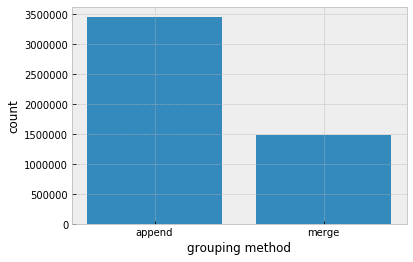

In [177]:
plt.bar(('append', 'merge'), (raw_shape, data.shape[0]))
plt.xlabel('grouping method')
plt.ylabel('count')
plt.savefig('images/grouping.pdf')

In [190]:
train = data.reset_index().merge(pd.DataFrame([], index=train_idxs), left_on='id', right_index=True)
test = data.reset_index().merge(pd.DataFrame([], index=test_idxs), left_on='id', right_index=True)

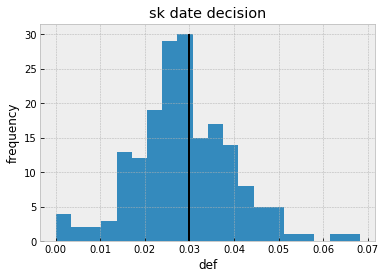

In [191]:
train.groupby('sk date decision')['def'].mean().plot.hist(bins=20)
plt.vlines(0.03, 0, 30)
plt.title('sk date decision')
plt.xlabel('def')
plt.ylabel('frequency')
plt.savefig('images/sk_date_decision.pdf')

In [196]:
train.groupby('sk date decision')[['id']].nunique().tail(5)

,id
sk date decision,
20160225.0,983
20160226.0,980
20160227.0,793
20160228.0,199
20160229.0,1075


In [199]:
test.groupby('sk date decision')[['id']].nunique().head(5)

,id
sk date decision,
20160301.0,999
20160302.0,892
20160303.0,917
20160304.0,896
20160305.0,630


In [134]:
test.groupby('sk date decision')['id'].nunique().index.sort_values()[:5]

Float64Index([20160301.0, 20160302.0, 20160303.0, 20160304.0, 20160305.0], dtype='float64', name='sk date decision')

In [135]:
train.drop('sk date decision', axis=1, inplace=True)
test.drop('sk date decision', axis=1, inplace=True)

In [143]:
from sklearn.metrics import roc_auc_score
defs = train.groupby('id')['def'].max()

In [144]:
pay = train[['id','text payment discipline']].copy()
pay.fillna(pay['text payment discipline'].mean(), inplace=True)

In [145]:
pay_mean = pay.groupby('id').mean()
roc_auc_score(defs, -pay_mean)

0.56805002626057577

In [146]:
pay_std = pay.groupby('id').std().fillna(0)
roc_auc_score(defs, -pay_std)

0.54504352792107991

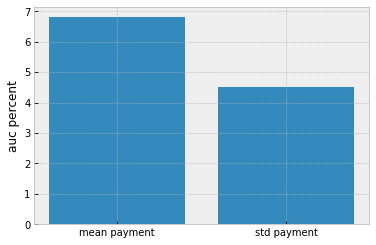

In [162]:
values = np.abs(np.array((roc_auc_score(defs, -pay_mean), roc_auc_score(defs, -pay_std))) - 0.5) * 100
plt.ylabel('auc percent')
plt.bar(('mean payment', 'std payment'), values)
plt.savefig('images/meanstd_auc.pdf')

In [167]:
names = ['hour', 'day', 'week', 'mon', 'qrt', 'year']

In [168]:
rocs = [roc_auc_score(defs, (train.groupby('id') \
    ['amt req source {}'.format(name)].sum() > 0).astype(int)) for name in names]
rocs = np.abs(np.array(rocs) - 0.5) * 100

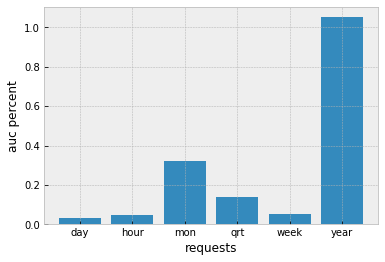

In [170]:
plt.bar(names, rocs)
plt.ylabel('auc percent')
plt.xlabel('requests')
plt.savefig('images/requests.pdf')

In [178]:
train['credit currency'] = train['credit currency'].apply(lambda x: 0 if x==0 else 1)
train['def'] = train['def'].apply(lambda x: int(x))
train.pivot_table('id', 'credit currency', 'def', 'count')

def,0,1
credit currency,,
0,748510,22998
1,979,30


In [155]:
roc_auc_score(defs, -train.groupby('id')['credit currency'].sum())

0.50016769706527386

In [186]:
rocs = list()
rocs.append(roc_auc_score(defs, train.groupby('id')['credit delay5'].sum()))
rocs.append(roc_auc_score(defs, train.groupby('id')['credit delay30'].sum()))
rocs.append(roc_auc_score(defs, train.groupby('id')['credit delay60'].sum()))
rocs.append(roc_auc_score(defs, train.groupby('id')['credit delay90'].sum()))
rocs.append(roc_auc_score(defs, train.groupby('id') \
    [['credit delay30', 'credit delay60']].sum().sum(axis=1)))
rocs = np.abs(np.array(rocs) - 0.5)*100

In [187]:
names = ('5', '30', '60', '90', '30+60')

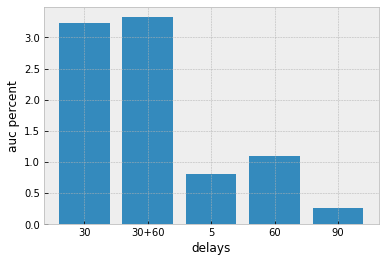

In [188]:
plt.bar(names, rocs)
plt.ylabel('auc percent')
plt.xlabel('delays')
plt.savefig('images/delays.pdf')